<a href="https://colab.research.google.com/github/sg-56/DLT_Workshop/blob/main/Workshop_2_0_Part1_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework

Write a python script that will load data from the Jikan API (Unofficial MyAnimeList API) into DuckDB using dlt and complete the tasks.

Use:
- @dlt.sourse
- @dlt.resource
- @dlt.transformer

Jikan API URL: https://api.jikan.moe/v4

Docs: https://docs.api.jikan.moe/#section/Information

Endpoints for loading:
- [anime](https://docs.api.jikan.moe/#tag/anime/operation/getAnimeSearch)
- [characters](https://docs.api.jikan.moe/#tag/characters/operation/getCharactersSearch)
- [anime/{id}/reviews](https://docs.api.jikan.moe/#tag/anime/operation/getAnimeReviews)


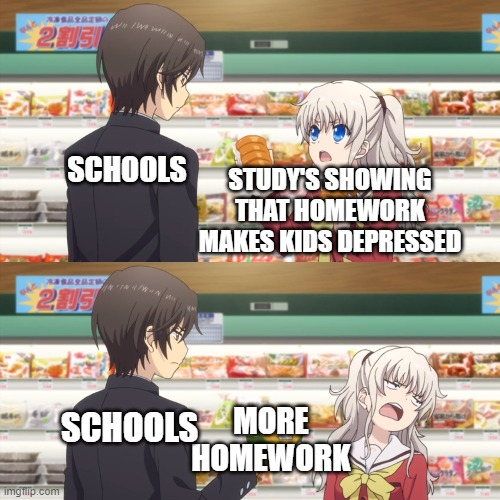

# Install dlt with duckdb extention

In [1]:
%%capture
!pip install dlt[duckdb]

# Play with API using requests library

In [2]:
import requests
response = requests.get("https://api.jikan.moe/v4/anime")
response.json()["data"][0]

{'mal_id': 1,
 'url': 'https://myanimelist.net/anime/1/Cowboy_Bebop',
 'images': {'jpg': {'image_url': 'https://cdn.myanimelist.net/images/anime/4/19644.jpg',
   'small_image_url': 'https://cdn.myanimelist.net/images/anime/4/19644t.jpg',
   'large_image_url': 'https://cdn.myanimelist.net/images/anime/4/19644l.jpg'},
  'webp': {'image_url': 'https://cdn.myanimelist.net/images/anime/4/19644.webp',
   'small_image_url': 'https://cdn.myanimelist.net/images/anime/4/19644t.webp',
   'large_image_url': 'https://cdn.myanimelist.net/images/anime/4/19644l.webp'}},
 'trailer': {'youtube_id': 'gY5nDXOtv_o',
  'url': 'https://www.youtube.com/watch?v=gY5nDXOtv_o',
  'embed_url': 'https://www.youtube.com/embed/gY5nDXOtv_o?enablejsapi=1&wmode=opaque&autoplay=1',
  'images': {'image_url': 'https://img.youtube.com/vi/gY5nDXOtv_o/default.jpg',
   'small_image_url': 'https://img.youtube.com/vi/gY5nDXOtv_o/sddefault.jpg',
   'medium_image_url': 'https://img.youtube.com/vi/gY5nDXOtv_o/mqdefault.jpg',
   'la

# Helper
Run the cell and ignore it.

In [3]:
from dlt.common.pipeline import LoadInfo

def assert_load_info(info: LoadInfo, expected_load_packages: int = 1) -> None:
    """Asserts that expected number of packages was loaded and there are no failed jobs"""
    assert len(info.loads_ids) == expected_load_packages
    # all packages loaded
    assert all(package.state == "loaded" for package in info.load_packages) is True
    # no failed jobs in any of the packages
    info.raise_on_failed_jobs()

# Task 1


- Create a pipeline for the API, for the next endpoints:
  - anime;
  - characters.

- Fill the empty lines in the functions below.
- Create a [resource](https://dlthub.com/docs/general-usage/resource#declare-a-resource) for the `characters` endpoint from scratch.
- Group them in `dlt.source`.
- [Run the pipeline](https://dlthub.com/docs/walkthroughs/run-a-pipeline) without errors.

In [4]:
import time

import dlt
import requests

@dlt.resource(table_name="anime")
def get_anime():
    url = "https://api.jikan.moe/v4/anime"
    data = requests.get(url).json()
    yield data["data"]



@dlt.resource(table_name="characters")
def get_characters():
    url = "https://api.jikan.moe/v4/characters"
    data = requests.get(url).json()
    yield data["data"]



@dlt.source
def load_info():
    return get_anime(),get_characters()

# put your code here


pipeline = dlt.pipeline(
    pipeline_name='anime_pipeline',
    destination='duckdb',
    dataset_name='anime_data',
    dev_mode=True,
)

load_info = pipeline.run(load_info())
print(load_info)
print(pipeline.last_trace.last_normalize_info)
assert_load_info(load_info)

Pipeline anime_pipeline load step completed in 1.42 seconds
1 load package(s) were loaded to destination duckdb and into dataset anime_data_20240921062711
The duckdb destination used duckdb:////content/anime_pipeline.duckdb location to store data
Load package 1726943231.354625 is LOADED and contains no failed jobs
Normalized data for the following tables:
- _dlt_pipeline_state: 1 row(s)
- anime: 25 row(s)
- anime__titles: 113 row(s)
- anime__producers: 78 row(s)
- anime__licensors: 31 row(s)
- anime__studios: 29 row(s)
- anime__genres: 79 row(s)
- anime__themes: 40 row(s)
- anime__title_synonyms: 25 row(s)
- anime__demographics: 17 row(s)
- characters: 25 row(s)
- characters__nicknames: 34 row(s)

Load package 1726943231.354625 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs


Run the code below and
## Answer the Questions:
**1.1** How many tables were generated by dlt during the normalisation step (see "Normalized data for the following tables:")? Including tables created by dlt (e.g. `_dlt_pipeline_state`).

**1.2** What anime has the highest score?

In [5]:
print(len(pipeline.last_trace.last_normalize_info.asdict()["load_packages"][0]["jobs"]))

12


Look at the data:

In [6]:
import duckdb
from google.colab import data_table
data_table.enable_dataframe_formatter()

# a database '<pipeline_name>.duckdb' was created in working directory so just connect to it
conn = duckdb.connect(f"{pipeline.pipeline_name}.duckdb")
conn.sql(f"SET search_path = '{pipeline.dataset_name}'")
stats_table = conn.sql("SELECT title_english, score FROM anime ORDER BY score DESC LIMIT 6;").df()
display(stats_table)

,title_english,score
0,Monster,8.88
1,Cowboy Bebop,8.75
2,One Piece,8.72
3,Berserk,8.59
4,Neon Genesis Evangelion: The End of Evangelion,8.55
5,Cowboy Bebop: The Movie,8.38


You could notice that we received only 1 page, only 25 records. But this endpoint has over 27k records in total (see below). To get all the pages you should use a pagination.

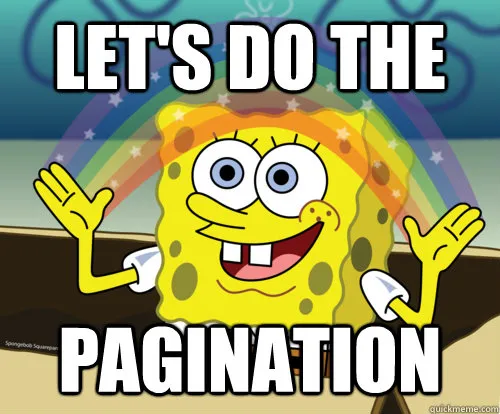

# Pagination

Play with requests, check out what pagination parameters you can use.

In [7]:
import requests
response = requests.get("https://api.jikan.moe/v4/anime")
response.json()['pagination']

{'last_visible_page': 1094,
 'has_next_page': True,
 'current_page': 1,
 'items': {'count': 25, 'total': 27330, 'per_page': 25}}

We can see that this endpoint has 27298 items in total.

Let's load only new anime released (with status "airing") in the last 3 month:

In [8]:
params = {
    "order_by": "start_date",
    "start_date": "2024-07-01",
    "status": "airing"
}

response = requests.get("https://api.jikan.moe/v4/anime", params=params)
print(response.json()["pagination"])
print(response.json()["data"][0])

{'last_visible_page': 4, 'has_next_page': True, 'current_page': 1, 'items': {'count': 25, 'total': 89, 'per_page': 25}}
{'mal_id': 54913, 'url': 'https://myanimelist.net/anime/54913/Shinmai_Ossan_Boukensha_Saikyou_Party_ni_Shinu_hodo_Kitaerarete_Muteki_ni_Naru', 'images': {'jpg': {'image_url': 'https://cdn.myanimelist.net/images/anime/1212/144711.jpg', 'small_image_url': 'https://cdn.myanimelist.net/images/anime/1212/144711t.jpg', 'large_image_url': 'https://cdn.myanimelist.net/images/anime/1212/144711l.jpg'}, 'webp': {'image_url': 'https://cdn.myanimelist.net/images/anime/1212/144711.webp', 'small_image_url': 'https://cdn.myanimelist.net/images/anime/1212/144711t.webp', 'large_image_url': 'https://cdn.myanimelist.net/images/anime/1212/144711l.webp'}}, 'trailer': {'youtube_id': 'juYfh7xTYdo', 'url': 'https://www.youtube.com/watch?v=juYfh7xTYdo', 'embed_url': 'https://www.youtube.com/embed/juYfh7xTYdo?enablejsapi=1&wmode=opaque&autoplay=1', 'images': {'image_url': 'https://img.youtube.c

# Task 2
- Add [pagination](https://www.getknit.dev/blog/api-pagination-best-practices) for endpoint `anime`.
- Add incremental loading for the resource `anime`. Use:
  - `aired.from` as a cursor,
  - `merge` write disposition,
  - `mal_id` as a  primary key.
  - `dlt.sources.incremental`,
  - "2024-07-01T00:00:00+00:00" as `initial_value`.

- Run the pipeline without errors.

Read more about [incremental loading](https://dlthub.com/docs/general-usage/incremental-loading).


WARNING: This API has [Rate Limits](https://docs.api.jikan.moe/#section/Information/Rate-Limiting). Try to reduce the number of pages during the development.

In [9]:
def pagination(url):
    params = {
    "order_by": "start_date",
    "start_date": "2024-07-01",
    "status": "airing"
}
    page = 1
    while True:
        # Construct the URL with pagination parameters
        full_url = f"{url}?page={page}"
        print(f"Fetching: {full_url}")

        response = requests.get(full_url,params = params)

        # Handle rate limiting
        if response.status_code == 429:
            print("Rate limit exceeded. Waiting for 3 seconds...")
            time.sleep(1)
            continue  # Retry the same page

        if response.status_code != 200:
            print(f"Error: {response.status_code}")
            break

        data = response.json()
        print(data['data'])  # You can remove this or log it as needed
        yield data['data']

        # Check if there are more pages
        if page >= data['pagination']['last_visible_page']:
            break

        page += 1
        # time.sleep(1)

In [10]:
d = pagination("https://api.jikan.moe/v4/anime")
for i in d:
  print(i)

Fetching: https://api.jikan.moe/v4/anime?page=1
[{'mal_id': 54913, 'url': 'https://myanimelist.net/anime/54913/Shinmai_Ossan_Boukensha_Saikyou_Party_ni_Shinu_hodo_Kitaerarete_Muteki_ni_Naru', 'images': {'jpg': {'image_url': 'https://cdn.myanimelist.net/images/anime/1212/144711.jpg', 'small_image_url': 'https://cdn.myanimelist.net/images/anime/1212/144711t.jpg', 'large_image_url': 'https://cdn.myanimelist.net/images/anime/1212/144711l.jpg'}, 'webp': {'image_url': 'https://cdn.myanimelist.net/images/anime/1212/144711.webp', 'small_image_url': 'https://cdn.myanimelist.net/images/anime/1212/144711t.webp', 'large_image_url': 'https://cdn.myanimelist.net/images/anime/1212/144711l.webp'}}, 'trailer': {'youtube_id': 'juYfh7xTYdo', 'url': 'https://www.youtube.com/watch?v=juYfh7xTYdo', 'embed_url': 'https://www.youtube.com/embed/juYfh7xTYdo?enablejsapi=1&wmode=opaque&autoplay=1', 'images': {'image_url': 'https://img.youtube.com/vi/juYfh7xTYdo/default.jpg', 'small_image_url': 'https://img.youtube

In [11]:
import time
import dlt
import requests




@dlt.resource(table_name="anime",
              write_disposition="merge",
              primary_key = "mal_id")
def get_anime(
    aired__from=dlt.sources.incremental("aired.from",initial_value="2024-07-01T00:00:00+00:00")# put your code here
):
    print(aired__from.keys())
    url = (
        f"https://api.jikan.moe/v4/anime"
    )
    yield pagination(url)


pipeline = dlt.pipeline(
    pipeline_name='anime_pipeline',
    destination='duckdb',
    dataset_name='anime_data',
    dev_mode=True,
)

load_info = pipeline.run(get_anime())
print(load_info)
print(pipeline.last_trace.last_normalize_info)
assert_load_info(load_info)





KeysView(<dlt.extract.incremental.Incremental object at 0x7a9f6187f100>)
Fetching: https://api.jikan.moe/v4/anime?page=1
Rate limit exceeded. Waiting for 3 seconds...
Fetching: https://api.jikan.moe/v4/anime?page=1
[{'mal_id': 54913, 'url': 'https://myanimelist.net/anime/54913/Shinmai_Ossan_Boukensha_Saikyou_Party_ni_Shinu_hodo_Kitaerarete_Muteki_ni_Naru', 'images': {'jpg': {'image_url': 'https://cdn.myanimelist.net/images/anime/1212/144711.jpg', 'small_image_url': 'https://cdn.myanimelist.net/images/anime/1212/144711t.jpg', 'large_image_url': 'https://cdn.myanimelist.net/images/anime/1212/144711l.jpg'}, 'webp': {'image_url': 'https://cdn.myanimelist.net/images/anime/1212/144711.webp', 'small_image_url': 'https://cdn.myanimelist.net/images/anime/1212/144711t.webp', 'large_image_url': 'https://cdn.myanimelist.net/images/anime/1212/144711l.webp'}}, 'trailer': {'youtube_id': 'juYfh7xTYdo', 'url': 'https://www.youtube.com/watch?v=juYfh7xTYdo', 'embed_url': 'https://www.youtube.com/embed/ju

## Answer the Questions:
**2.1.**  How many rows has `anime__titles` table?

**2.2** What anime has the highest score now?

In [12]:
import duckdb
from google.colab import data_table
data_table.enable_dataframe_formatter()

# a database '<pipeline_name>.duckdb' was created in working directory so just connect to it
conn = duckdb.connect(f"{pipeline.pipeline_name}.duckdb")
conn.sql(f"SET search_path = '{pipeline.dataset_name}'")
stats_table = conn.sql("SELECT title_english, score FROM anime ORDER BY score DESC LIMIT 4;").df()
display(stats_table)

,title_english,score
0,Monogatari Series: Off & Monster Season,9.03
1,[Oshi No Ko] Season 2,8.55
2,Makeine: Too Many Losing Heroines!,8.34
3,NieR:Automata Ver1.1a (Cour 2),7.96


# Task 3: Get reviews with dlt.transformer

- Use `@dlt.transformer` to get additional info for your data.

- Use endpoint `anime/{id}/reviews` to get reviews for anime endpoint from task 1 (one page, without pagination and incremental loading).
- Don't forget to handle Rate Limits errors.
- Run pipeline without errors.

Read more about dlt [transformers](https://dlthub.com/docs/general-usage/resource#process-resources-with-dlttransformer).

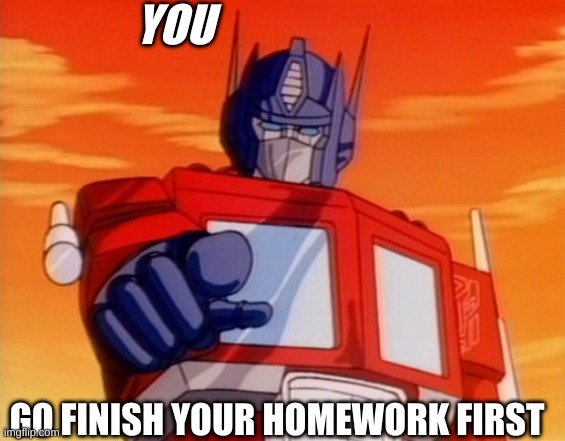

In [13]:
import time
import dlt
import requests


import time
import dlt
import requests




@dlt.resource(table_name="anime",
              write_disposition="merge",
              primary_key = "mal_id")
def get_anime():
    # print(aired__from.keys())
    url = (
        f"https://api.jikan.moe/v4/anime"
    )
    response = requests.get(url).json()['data']
    # print(response.json()['data'])
    yield response




@dlt.transformer(data_from=get_anime, table_name='anime_reviews')
def get_reviews(items):
    for anime in items:
        # print(anime)
        id = anime['mal_id']
        url = f"https://api.jikan.moe/v4/anime/{id}/reviews"
        response = requests.get(url).json()
        print(response.get('data'))
        yield response.get('data')




pipeline = dlt.pipeline(
    pipeline_name='anime_pipeline',
    destination='duckdb',
    dataset_name='anime_data_tr',
    dev_mode=True,
)

data = get_anime | get_reviews

load_info = pipeline.run(data())
print(load_info)
print(pipeline.last_trace.last_normalize_info)
assert_load_info(load_info)

[{'mal_id': 7406, 'url': 'https://myanimelist.net/reviews.php?id=7406', 'type': 'anime', 'reactions': {'overall': 2231, 'nice': 2191, 'love_it': 18, 'funny': 4, 'confusing': 1, 'informative': 8, 'well_written': 9, 'creative': 0}, 'date': '2008-08-24T05:46:00+00:00', 'review': "People who know me know that I'm not a fan of episodic anime series unless they're either one season (12-14 episodes) long or a slice of life series. Why? They have a tendency to get boring, or repetitive. But all rules and preferences have exceptions. You know what? Cowboy Bebop is that exception. The story is set in a space western setting - a genre and setting I'm loving more and more for each show I watch that falls under the genre. We follow two bounty hunters, Spike and Jet, who own a ship called the Bebop. They travel the Solar system, chasing wanted criminals toearn money. Along the way, they also pick up two women; the debt-laden Faye Valentine and the playful kid and computer genius Edward (yes, Ed&amp;

Run the code below and

## Answer the Questions:

**3.1** How many tables were generated by dlt during the normalisation step (see "Normalized data for the following tables:")? Including tables created by dlt (e.g. `_dlt_pipeline_state`).

**3.2** Which username got the most overall reactions?

In [17]:
print(len(pipeline.last_trace.last_normalize_info.asdict()["load_packages"][0]["jobs"]))

10


In [14]:
import duckdb
from google.colab import data_table
data_table.enable_dataframe_formatter()

# a database '<pipeline_name>.duckdb' was created in working directory so just connect to it
conn = duckdb.connect(f"{pipeline.pipeline_name}.duckdb")
conn.sql(f"SET search_path = '{pipeline.dataset_name}'")
# list all tables
display(conn.sql("DESCRIBE"))

stats_table = conn.sql("SELECT user__username, reactions__overall, review FROM anime_reviews ORDER BY reactions__overall DESC LIMIT 5;").df()
print(stats_table.columns)
display(stats_table)

┌────────────────┬──────────────────────┬──────────────────────┬───┬──────────────────────┬───────────┐
│    database    │        schema        │         name         │ … │     column_types     │ temporary │
│    varchar     │       varchar        │       varchar        │   │      varchar[]       │  boolean  │
├────────────────┼──────────────────────┼──────────────────────┼───┼──────────────────────┼───────────┤
│ anime_pipeline │ anime_data_2024092…  │ _dlt_loads           │ … │ [VARCHAR, VARCHAR,…  │ false     │
│ anime_pipeline │ anime_data_2024092…  │ _dlt_pipeline_state  │ … │ [BIGINT, BIGINT, V…  │ false     │
│ anime_pipeline │ anime_data_2024092…  │ _dlt_version         │ … │ [BIGINT, BIGINT, T…  │ false     │
│ anime_pipeline │ anime_data_2024092…  │ anime                │ … │ [BIGINT, VARCHAR, …  │ false     │
│ anime_pipeline │ anime_data_2024092…  │ anime__demographics  │ … │ [BIGINT, VARCHAR, …  │ false     │
│ anime_pipeline │ anime_data_2024092…  │ anime__genres        │

Index(['user__username', 'reactions__overall', 'review'], dtype='object')


,user__username,reactions__overall,review
0,TheLlama,2231,People who know me know that I'm not a fan of ...
1,Polyphemus,1601,Cowboy Bebop is one of those series that is ju...
2,TheLlama,1404,"To be honest, Naruto is the most overhyped sho..."
3,Xinil,885,"Trigun is another one of my ""must see in your ..."
4,theeggman85,882,I began to browse through the reviews of Narut...


# Bonus
There are no tasks, just a top 5 Anime according to
 MyAnimeList database 😉

In [15]:
import time

import dlt
import requests


@dlt.resource(table_name="top_anime")
def get_top_anime():
    response = requests.get("https://api.jikan.moe/v4/top/anime")
    yield response.json()["data"]


pipeline = dlt.pipeline(
    pipeline_name='anime_pipeline',
    destination='duckdb',
    dataset_name='anime_data',
    dev_mode=True,
)

load_info = pipeline.run(get_top_anime())
print(load_info)
print(pipeline.last_trace.last_normalize_info)


Pipeline anime_pipeline load step completed in 1.23 seconds
1 load package(s) were loaded to destination duckdb and into dataset anime_data_20240921062743
The duckdb destination used duckdb:////content/anime_pipeline.duckdb location to store data
Load package 1726943263.8259132 is LOADED and contains no failed jobs
Normalized data for the following tables:
- _dlt_pipeline_state: 1 row(s)
- top_anime: 25 row(s)
- top_anime__titles: 153 row(s)
- top_anime__title_synonyms: 47 row(s)
- top_anime__producers: 128 row(s)
- top_anime__studios: 27 row(s)
- top_anime__genres: 72 row(s)
- top_anime__demographics: 19 row(s)
- top_anime__licensors: 22 row(s)
- top_anime__themes: 56 row(s)

Load package 1726943263.8259132 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs


In [16]:
import duckdb
from google.colab import data_table
data_table.enable_dataframe_formatter()

# a database '<pipeline_name>.duckdb' was created in working directory so just connect to it
conn = duckdb.connect(f"{pipeline.pipeline_name}.duckdb")
conn.sql(f"SET search_path = '{pipeline.dataset_name}'")
stats_table = conn.sql("SELECT title_english, score FROM top_anime ORDER BY score DESC LIMIT 5;").df()
display(stats_table)

,title_english,score
0,Frieren: Beyond Journey's End,9.33
1,Fullmetal Alchemist: Brotherhood,9.09
2,Steins;Gate,9.07
3,Gintama Season 4,9.06
4,Attack on Titan Season 3 Part 2,9.05
